In this notebook I'll go through some work I did for a recent political campaign where we needed to predict the affiliation of voters whose ballots were invalidated. We wanted to sue to restore the validity of many ballots - but obviously we wanted to prioritize those ballots who we had good reason to think voted for our candidate. 

Our candidate being young, progressive, and Latin american, we had good reason to expect that age, ethnicity, and geography (ie more left-leaning neighorhoods) were reasonable factors to influence voter affiliation. In the following map, brighter yellow areas are the strongest for our candidate relative to the primary opponent, and dark purple areas are strongest for the primary opponent relative to our candidate. 
<img src="https://illesial.github.io/images/weight_map.png" alt="Voting preference by geography" width="360"/>
<!--excerpt-->

However, this demographic and geographic information wasn't all we had to go off of - we actually conducted a poll of some of these voters and determined whether or not they voted for our candidate. 

Using this voting data, the aforementioned demographics and geographical data, I trained a popular machine learning classification model, [Random Forest](https://en.wikipedia.org/wiki/Random_forest), so that we could predict the affiliation of the rest of the voters whose ballots were invalidated, and hence prioritize them in our legal case.


## Importing Packages

We'll proceed with building our model by importing `pandas`, `numpy`, our model, parameter tuning tools, and metrics from `sklearn`.

In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
from sklearn.model_selection import train_test_split

### MODELS TO USE
from sklearn.ensemble import RandomForestClassifier

# PARAMETER TUNING / CROSS VALIDATION TOOLS

from sklearn.model_selection import GridSearchCV

### MODEL EVALUATION METRICS TO USE

from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

## Loading Data
Next, we'll load our data using `pandas` as the dataframe `df`. The data has already been scaled and stored in the `model_variables_pred.csv` file. 

In [14]:
df=pd.read_csv('model_variables_pred.csv')
df.head()

,Candidate,age_scaled,latinx_score,weight
0,1,0.354839,0.666667,0.314516
1,1,0.344086,0.000000,0.907143
2,1,0.268817,0.000000,0.900000
3,0,0.569892,1.000000,0.898990
4,1,0.354839,0.000000,0.894737


Each row in this dataframe corresponds to an individual voter (anonymized).

The columns correspond to the demographic and voting information provided above; `Candidate` denotes the affiliation of the voter, we have our age and ethnicity, columns `age_scaled` and `latinx_score`, and finally we have the column `weight`. 

The `weight` column is represented by the map at the top of the notebook, and indicates the preferences of voters overall within the home Election District of the corresponding voter, for our candidate relative to the primary opponent. 

A little bit more about the visualization will be helpful here; I used the geographic data analysis package `geopandas` to load the file `EDs_weight.shp`, which is a shapefile indicating the weight scores for each Election District.

<Figure size 432x288 with 0 Axes>

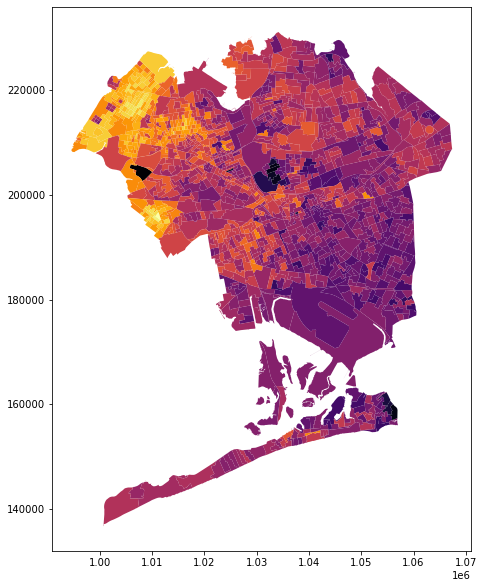

In [15]:
import geopandas as gpd
EDs_weight = gpd.read_file('EDs_weight.shp')
EDs_weight.to_crs(epsg=4326);

plt.clf()
EDs_weight.plot('weight', figsize=(10,10),cmap='inferno')
plt.show()

A couple notes about the above code: after loading the shapefile as a geodataframe, we have to set the coordinate system, which in this case is [EPSG:4326](https://epsg.io/4326). These coordinates are visible on the edges of the above map. 

In this map, brighter yellow areas are the strongest for our candidate relative to the primary opponent, and dark purple areas are strongest for the primary opponent relative to our candidate. This is the information encoded into the weight column; each voter's home district gets a score, called weight, and this score is assigned to them in the `weight` column within the dataframe `df`. 

## Setting Prediction and Target Variables and Filling in Missing Data

Let's proceed by setting our prediction variables `X` and target variable `y` to be the columns corresponding to age, ethnicity, weight, and candidate preference respectively:

In [18]:
X = df[['age_scaled', 'latinx_score', 'weight']]
y = df['Candidate']

Next we'll fill any missing data:

In [19]:
y = y.fillna(value=0)

In [20]:
mean_list = X.mean().tolist()

In [23]:
X['age_scaled']=X['age_scaled'].fillna(value=mean_list[0])
X['latinx_score']=X['latinx_score'].fillna(value=mean_list[1])
X['weight']=X['weight'].fillna(value=mean_list[2])

## Split into Train and Test sets
Now that our data is cleaned and split into Predictor and target variables `X` and `y`, we can split our data into training and test sets using a 40% holdout size for the test set:

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

## Hyperparameter Tuning

Instead of jumping right in to training our model using the `RandomForestClassifier()`, we'll set up a parameter grid `param_grid_rf` so that we can optimize our model using [Hyperparameter Tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization). 

In [25]:
def round_to_int(x):
    return int(np.rint(x))

num_cols = len(X_train.columns)
n_est_space=np.array([round_to_int(x) for x in np.logspace(1, 1.5, num = 20)])
max_feat_space=np.arange(round_to_int(np.sqrt(num_cols) / 2), round_to_int(np.sqrt(num_cols) * 2) + 1)

param_grid_rf = {'n_estimators': n_est_space, 'max_features': max_feat_space}

## Training our model

Now with our parameter grid set up, we'll use `GridSearchCV()` to tune parameters and fit our Random Forest classifier `rand_forest`:

In [27]:
rand_forest = RandomForestClassifier()

rand_forest_cv = GridSearchCV(rand_forest, param_grid_rf, cv = 5, iid=True)
rand_forest_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'n_estimators': array([10, 11, 11, 12, 13, 14, 14, 15, 16, 17, 18, 19, 21, 22, 23, 25, 26,
       28, 30, 32]), 'max_features': array([1, 2, 3])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Now we can see our optimal parameters and accuracy:

In [44]:
print("Tuned Random Forest Parameters: {}".format(rand_forest_cv.best_params_))
print("Tuned Random Forest Accuracy: {}".format(rand_forest_cv.best_score_))

Tuned Random Forest Parameters: {'max_features': 1, 'n_estimators': 13}
Tuned Random Forest Accuracy: 0.7283950617283951


Let's also check out our classificication report:

In [45]:
y_pred_rf = rand_forest_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[12 30]
 [30 91]]
             precision    recall  f1-score   support

          0       0.29      0.29      0.29        42
          1       0.75      0.75      0.75       121

avg / total       0.63      0.63      0.63       163



Worth noting is that I checked the performance of other popular classifiers, such as K-Nearest Neighors, Logistic Regression, and Support Vector Classification, but (somewhat unsurprisingly), Random Forest performed the best.

## Conclusion

We trained a Random Forest classifier on our voting, demographic, and geographic data to predict voter affiliation. Our accuracy is about 73% and we have an f1 score of `0.63`. While not perfect, our model undoubtedly helped us determine which voters to prioritize in our legal case. 